# Fashion MNIST Binary Classification

This notebook demonstrates how to build a neural network for binary classification using the Fashion MNIST dataset. We'll convert the original 10-class problem into a binary problem by grouping the classes into two categories:
- **Clothing (Vestuario)**: T-Shirt/Top, Trouser, Pullover, Dress, Coat (classes 0-4)
- **Footwear & Bags (Calçado e malas)**: Sandal, Shirt, Sneaker, Bag, Boot (classes 5-9)

Let's start by importing the necessary libraries and setting up our constants.

In [2]:
# Common imports for our neural network project
import tensorflow as tf
import keras
from keras import layers

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# Image dimensions constants
IMG_HEIGHT = 28
IMG_WIDTH = 28

# Original Fashion MNIST labels/classes
LABELS = ["T-Shirt/Top",
          "Trouser",
          "Pullover",
          "Dress",
          "Coat",
          "Sandal",
          "Shirt",
          "Sneaker",
          "Bag",
          "Boot"]
N_CLASSES = 10

# Binary classification labels
BINARY_LABELS = ['Vestuario', 'Calçado e malas']

# Callbacks for model training
BEST_MODEL_CHECKPOINT = keras.callbacks.ModelCheckpoint(
    filepath="tmp/best_modelpart2.weights.h5",  # File to save the weights of the "best model"
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

EARLY_STOPPING = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5)  # Stop training if validation loss doesn't improve for 5 epochs

## 1. Data Loading and Preprocessing

Next, we'll load the Fashion MNIST dataset and prepare it for training:
1. Load the dataset using Keras
2. Normalize the pixel values to the range [0,1]
3. Split the training data to create a validation set (80% training, 20% validation)

In [3]:
# Load the Fashion MNIST dataset
dataset = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = dataset.load_data()

# Normalize pixel values to [0,1] range
x_train = x_train / 255.0
x_test = x_test / 255.0

# Create validation set (80% train, 20% validation)
split = int(0.80 * x_train.shape[0])

x_val = x_train[split:]
y_val = y_train[split:]

x_train = x_train[:split]
y_train = y_train[:split]

# Print dataset shapes to verify
print(f"Training set shape: {x_train.shape}, {y_train.shape}")
print(f"Validation set shape: {x_val.shape}, {y_val.shape}")
print(f"Test set shape: {x_test.shape}, {y_test.shape}")

Training set shape: (48000, 28, 28), (48000,)
Validation set shape: (12000, 28, 28), (12000,)
Test set shape: (10000, 28, 28), (10000,)


## 2. Convert to Binary Classification Problem

Now we'll convert the multiclass problem (10 classes) into a binary classification:
- Classes 0-4 (T-Shirt/Top, Trouser, Pullover, Dress, Coat) → Class 1 (Clothing/Vestuario)
- Classes 5-9 (Sandal, Shirt, Sneaker, Bag, Boot) → Class 0 (Footwear & Bags/Calçado e malas)

In [4]:
# Convert labels to binary classification
# If original class < 5 (clothing items): assign 1
# If original class >= 5 (footwear & bags): assign 0
y_train = np.where(y_train < 5, 1, 0)
y_test = np.where(y_test < 5, 1, 0)
y_val = np.where(y_val < 5, 1, 0)

# Display class distribution
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Validation set class distribution: {np.bincount(y_val)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

Training set class distribution: [24093 23907]
Validation set class distribution: [5907 6093]
Test set class distribution: [5000 5000]


## 3. Visualize Example Images

Let's visualize some examples from each binary class to understand our data better:

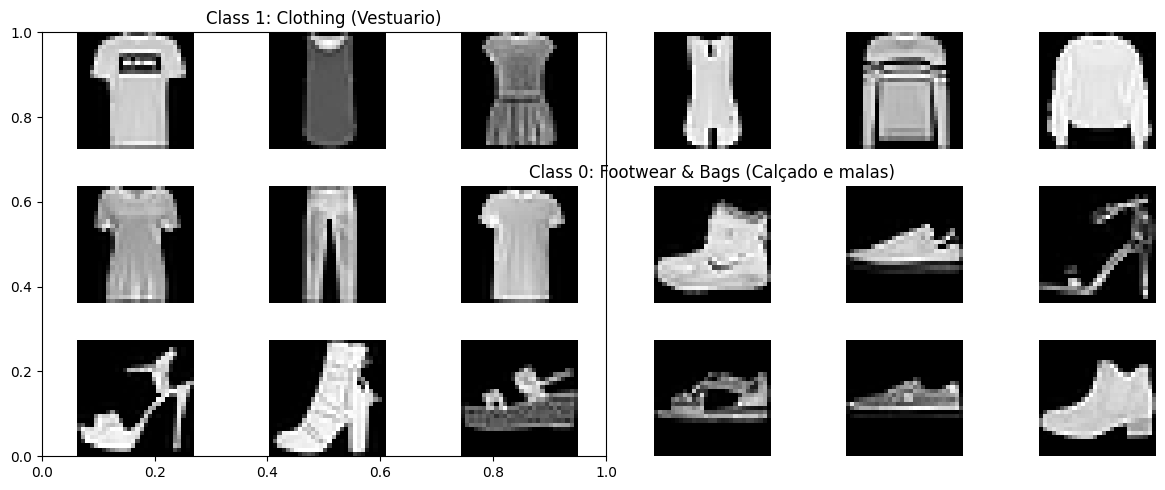

In [5]:
# Visualize some examples from each binary class
plt.figure(figsize=(12, 5))

# Examples from Class 1 (Clothing/Vestuario)
plt.subplot(1, 2, 1)
plt.title('Class 1: Clothing (Vestuario)')
clothing_indices = np.where(y_train == 1)[0][:9]
for i, idx in enumerate(clothing_indices[:9]):
    plt.subplot(3, 6, i+1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.axis('off')
    
# Examples from Class 0 (Footwear & Bags/Calçado e malas)
footwear_indices = np.where(y_train == 0)[0][:9]
for i, idx in enumerate(footwear_indices[:9]):
    plt.subplot(3, 6, i+10)
    plt.imshow(x_train[idx], cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Class 0: Footwear & Bags (Calçado e malas)')

plt.tight_layout()
plt.show()

## 4. Model Architecture

Now we'll build a simple neural network for binary classification:
1. Input layer for 28×28 grayscale images
2. Flatten layer to convert 2D images to 1D
3. Dense hidden layer with ReLU activation
4. Output layer with sigmoid activation for binary classification

In [6]:
# Initialize weights with random normal distribution for reproducibility
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=12345)

# Create sequential model for binary classification
my_model_binary = keras.Sequential([
    layers.Input(shape=(28, 28)),          # Input layer - 28×28 grayscale images
    layers.Flatten(),                      # Flatten 2D images to 1D vectors
    layers.Dense(520, activation='relu',   # Hidden layer with 520 neurons and ReLU activation
                kernel_initializer=initializer),
    layers.Dense(1, activation='sigmoid',  # Output layer - sigmoid for binary classification
                kernel_initializer=initializer)
])

# Compile the model
my_model_binary.compile(
    loss="binary_crossentropy",            # Loss function for binary classification
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Adam optimizer
    metrics=["accuracy"])                  # Track accuracy during training

# Display model summary
my_model_binary.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 520)            │       408,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           521 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 408,721 (1.56 MB)

 Trainable params: 408,721 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Model Training

Let's train our model for 50 epochs with the following settings:
- Batch size: 64
- Using validation data for performance monitoring
- Saving the best model based on validation loss

In [7]:
# Train the model
history = my_model_binary.fit(
    x_train, y_train,                    # Training data
    batch_size=64,                       # Batch size for gradient updates
    epochs=50,                          # Maximum number of epochs
    validation_data=(x_val, y_val),      # Validation data for monitoring
    callbacks=[BEST_MODEL_CHECKPOINT, EARLY_STOPPING]  # Save best model and stop early if needed
)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8994 - loss: 0.2339 - val_accuracy: 0.9251 - val_loss: 0.1720
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9290 - loss: 0.1670 - val_accuracy: 0.9332 - val_loss: 0.1565
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9353 - loss: 0.1519 - val_accuracy: 0.9363 - val_loss: 0.1518
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9370 - loss: 0.1452 - val_accuracy: 0.9404 - val_loss: 0.1409
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9420 - loss: 0.1374 - val_accuracy: 0.9406 - val_loss: 0.1388
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9447 - loss: 0.1308 - val_accuracy: 0.9432 - val_loss: 0.1363
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9463 - loss: 0.1251 - val_accuracy: 0.9440 - val_loss: 0.1350
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9505 - loss: 0.1205 - val_accuracy: 0.

## 6. Model Evaluation

Now let's evaluate our model on the test set and make predictions:

In [8]:
# Get ground truth labels
y_true = y_test

# Make predictions on test set
output_pred = my_model_binary.predict(x_test)

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = np.where(output_pred > 0.5, 1, 0)
y_pred = y_pred.reshape(y_pred.shape[0])

# Print first few predictions and ground truth
print("First 10 predictions (probability):\n", output_pred[:10].flatten())
print("\nFirst 10 predictions (binary):\n", y_pred[:10])
print("\nFirst 10 ground truth labels:\n", y_true[:10])

# Calculate and display accuracy
accuracy = np.mean(y_pred == y_true)
print(f"\nTest accuracy: {accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
First 10 predictions (probability):
 [3.1203783e-16 9.9999624e-01 9.9999982e-01 9.9999630e-01 3.2629302e-01
 9.9999446e-01 9.9962288e-01 2.4823009e-04 1.4781485e-06 5.7028892e-18]

First 10 predictions (binary):
 [0 1 1 1 0 1 1 0 0 0]

First 10 ground truth labels:
 [0 1 1 1 0 1 1 0 0 0]

Test accuracy: 0.9393


## 7. Visualizing Results

Finally, let's visualize our model's performance using:
1. Accuracy curves (training vs. validation)
2. Loss curves (training vs. validation)
3. Confusion matrix

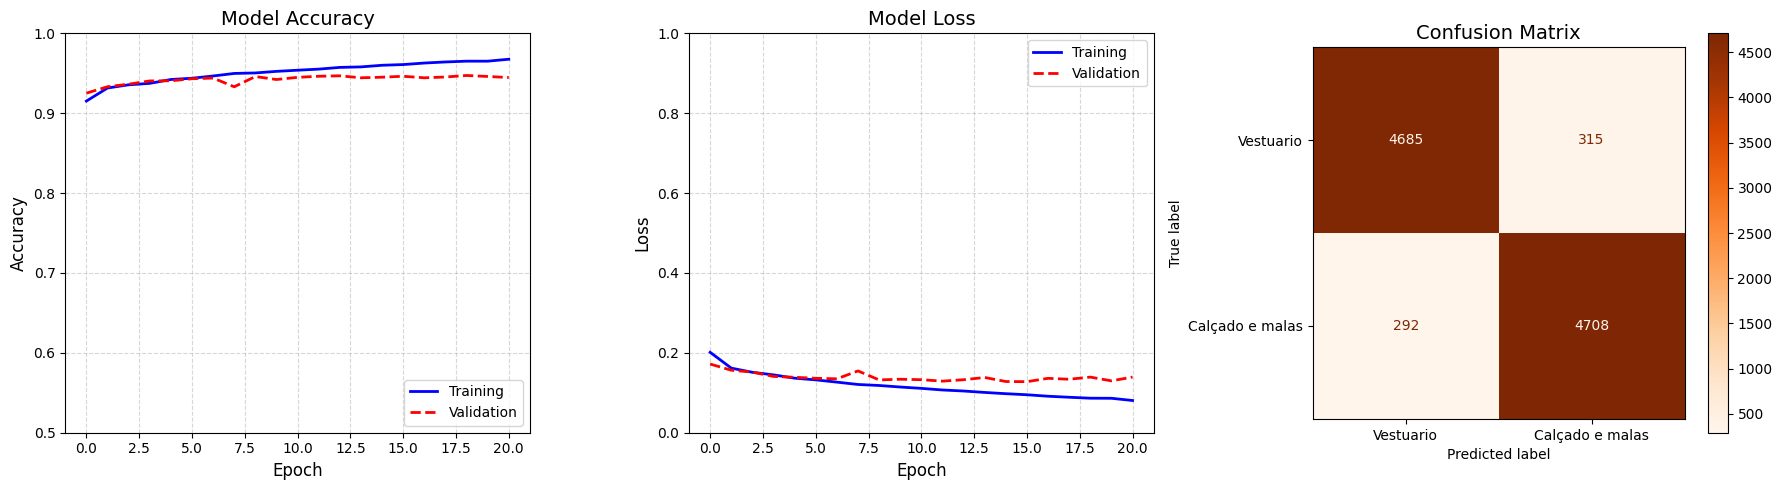

Confusion Matrix:
                         Predicted
                   Vestuario    Calçado e malas
Actual Vestuario      4685       315
       Calçado e malas      292       4708


In [9]:
# Set up a figure with multiple subplots
plt.figure(figsize=(18, 5))

# 1. Plot training and validation accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], 'b-', linewidth=2)
plt.plot(history.history['val_accuracy'], 'r--', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylim(0.5, 1.0)
plt.legend(['Training', 'Validation'], loc="lower right")
plt.grid(True, ls='--', alpha=0.5)

# 2. Plot training and validation loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], 'b-', linewidth=2)
plt.plot(history.history['val_loss'], 'r--', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.ylim(0, 1.0)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Training', 'Validation'], loc="upper right")
plt.grid(True, ls='--', alpha=0.5)

# 3. Plot confusion matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=BINARY_LABELS
)
disp.plot(cmap=plt.colormaps['Oranges'], ax=plt.gca(), values_format='d')
plt.title('Confusion Matrix', fontsize=14)

plt.tight_layout()
plt.show()

# Display the confusion matrix values
print("Confusion Matrix:")
print(f"                         Predicted")
print(f"                   {BINARY_LABELS[0]}    {BINARY_LABELS[1]}")
print(f"Actual {BINARY_LABELS[0]}      {cm[0,0]}       {cm[0,1]}")
print(f"       {BINARY_LABELS[1]}      {cm[1,0]}       {cm[1,1]}")

## 8. Visualize Some Misclassified Examples

Let's examine some examples where our model made mistakes to understand its limitations:

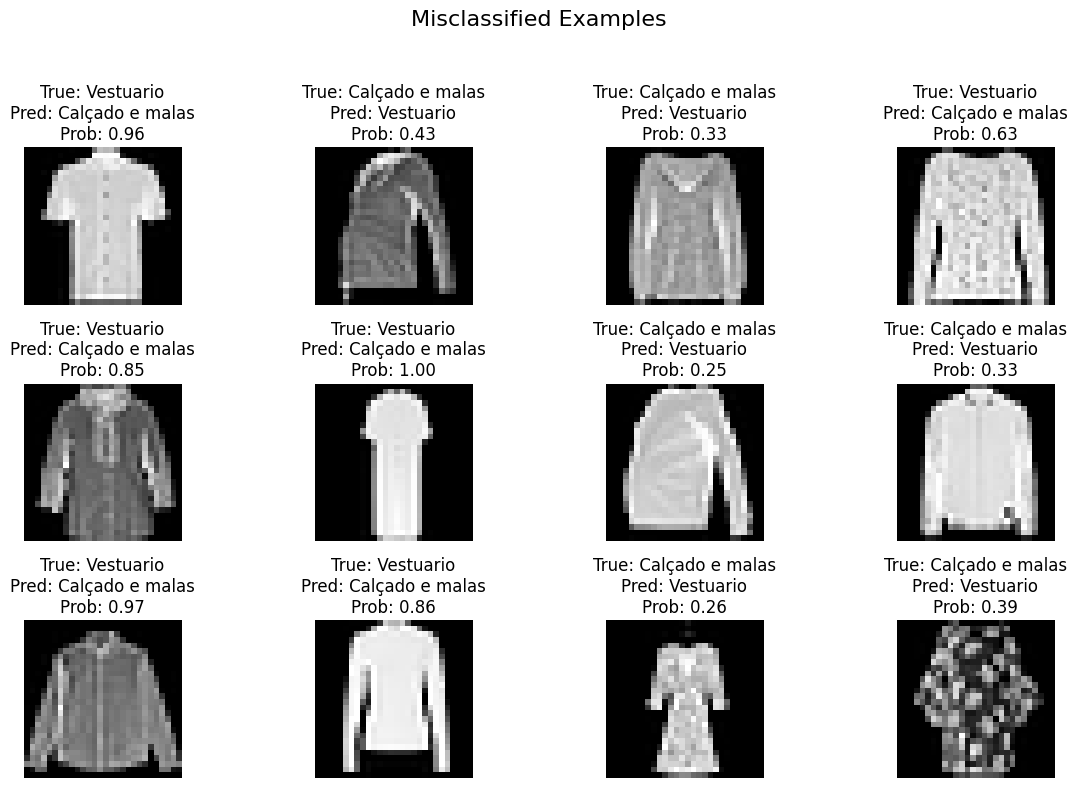

Total misclassified examples: 607 out of 10000 test examples
Error rate: 6.07%


In [10]:
# Find indices of misclassified examples
misclassified_indices = np.where(y_pred != y_true)[0]

if len(misclassified_indices) > 0:
    # Show a sample of misclassified examples
    plt.figure(figsize=(12, 8))
    plt.suptitle('Misclassified Examples', fontsize=16)
    
    for i, idx in enumerate(misclassified_indices[:12]):
        plt.subplot(3, 4, i+1)
        plt.imshow(x_test[idx], cmap='gray')
        plt.title(f"True: {BINARY_LABELS[y_true[idx]]}\nPred: {BINARY_LABELS[y_pred[idx]]}\nProb: {output_pred[idx][0]:.2f}")
        plt.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    print(f"Total misclassified examples: {len(misclassified_indices)} out of {len(y_test)} test examples")
    print(f"Error rate: {len(misclassified_indices)/len(y_test):.2%}")
else:
    print("No misclassified examples found!")

## 9. Conclusion

In this notebook, we've successfully:

1. Loaded and preprocessed the Fashion MNIST dataset
2. Converted the multiclass problem into a binary classification task
3. Built and trained a neural network for this task
4. Evaluated the model's performance using various metrics
5. Visualized the results and examined misclassified examples

Our model achieves good accuracy in distinguishing between clothing items and footwear/bags. The confusion matrix helps us understand the balance between false positives and false negatives.

### Possible Improvements

1. Try different model architectures (add more layers or use CNN)
2. Experiment with different hyperparameters (learning rate, batch size)
3. Apply data augmentation to improve generalization
4. Use regularization techniques to prevent overfitting